In [24]:
# If you are a developer, you may want to reload the packages on the fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

# import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, subprocess
from scipy.stats import bootstrap
from textwrap import wrap
from matplotlib import font_manager
font_dirs = ["/home/izhegalova/fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
susielu = ["#b84873", "#6dbc5f","#5a3789","#bdab3d","#6d80d8","#bd7635","#bf68b8","#46c19a","#ba4b41","#71883b"]
sns.set_theme(context="paper", style='white', palette=susielu, font="Arial")

os.chdir('/home/izhegalova/ecoli_microc')

# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe as bf
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting
import coolpuppy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
print(cooltools.__version__)
print(bf.__version__)
print(cooler.__version__)
# print(coolpuppy.__version__)

0.7.0
0.6.4
0.9.3


# HicRep

In [48]:
from hicrep.utils import readMcool
fmcool1 = "data/cool_reps/rif750_rep1.MG1655.mapq_30.10.mcool"
fmcool2 = "data/cool_reps/rif750_rep2.MG1655.mapq_30.10.mcool"
binSize = 100
cool1, binSize1 = readMcool(fmcool1, binSize)
cool2, binSize2 = readMcool(fmcool2, binSize)

In [55]:
from hicrep import hicrepSCC

# smoothing window half-size
h = 30

# maximal genomic distance to include in the calculation
dBPMax = 100_000

# whether to perform down-sampling or not 
# if set True, it will bootstrap the data set # with larger contact counts to
# the same number of contacts as in the other data set; otherwise, the contact 
# matrices will be normalized by the respective total number of contacts
bDownSample = False

# compute the SCC score
# this will result in a SCC score for each chromosome available in the data set
# listed in the same order as the chromosomes are listed in the input Cooler files
# scc = hicrepSCC(cool1, cool2, h, dBPMax, bDownSample)
scc
# Optionally you can get SCC score from a subset of chromosomes
# sccSub = hicrepSCC(cool1, cool2, h, dBPMax, bDownSample, np.array(['myChr1', 'myOtherChr'], dtype=str))


array([0.99134494])

In [56]:
cooler_dir='data/cool_reps/'
cooler_names = []
cooler_files = []
for fname in sorted(os.listdir(cooler_dir)):
    cooler_path = os.path.join(cooler_dir, fname)  # + '::/resolutions/2000'
    if os.path.isdir(cooler_path):
        # skip directories
        continue
    else:
        cooler_names.append(fname.split(".")[0])
        cool_file, binSize1 = readMcool(cooler_path, binSize)
        cooler_files.append(cool_file)

In [57]:
ordered_pairs = c = [(i, j) for i in range(8) for j in range(8)]
cor_list = []
for i in range(len(ordered_pairs)):
    scc = hicrepSCC(cooler_files[ordered_pairs[i][0]],
                    cooler_files[ordered_pairs[i][1]],
                    h, dBPMax, bDownSample)
    cor_list.append([ordered_pairs[i][0], ordered_pairs[i][1], scc[0]])

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/hicrep/hicrep.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert (cool1.chroms()[:] == cool2.chroms()[:]).all()[0],\
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/hicrep/hicrep.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert (cool1.chroms()[:] == cool2.chroms()[:]).all()[0],\
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/hicrep/hicrep.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

In [94]:
df = pd.DataFrame(cor_list)
df.columns = ['cool1', 'cool2', 'cor']
di = {0: "rif25_rep1", 1: "rif25_rep2", 2: "rif750_rep1", 3: "rif750_rep2",
     4: "44С_rep1", 5: "44С_rep2", 6: "37С_rep1", 7: "37С_rep2"}
df = df.replace({"cool1": di, "cool2": di}).sort_values(['cool1', 'cool2'])

df_pivot = df.pivot(index='cool1', columns='cool2', values='cor')
df_pivot.head()
# df_pivot.columns = cooler_names
# df_pivot['sample'] = cooler_names
# sample_names = ['37С_rep1', '37C_rep2', '44C_rep1', '44C_rep2', 
#                 'rif25_rep1', 'rif25_rep2', 'rif750_rep1', 'rif750_rep']
# df_pivot = df_pivot.reindex(index=sample_names, 
#                  columns=sample_names)
# df_pivot.head()
df_pivot.to_csv('results/cor.h30.tsv', sep='\t')

In [76]:
# df_tra = df_pivot[df_pivot.columns[::-1]]

df_tra = pd.DataFrame(np.flip(np.flip(df_pivot.to_numpy(), 0), 1))

df_tra.columns = sample_names
df_tra['sample'] = sample_names
df_tra = df_tra.set_index('sample')

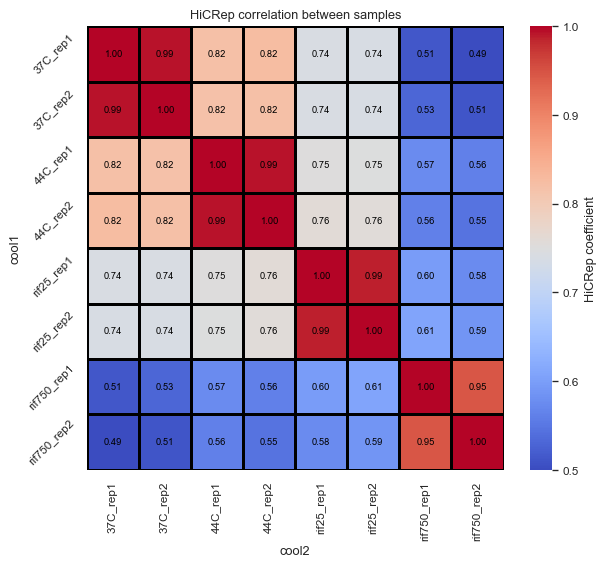

In [96]:
f, ax = plt.subplots(
    figsize=(7,6))
sns.heatmap(data=df_pivot, annot=True, fmt='.2f', cmap='coolwarm', 
            ax=ax, vmin=0.5, vmax=1, annot_kws={"size": 7, 'color':'black'}, 
            linewidths=1, linecolor='black', 
            cbar_kws={'label': 'HiCRep coefficient'})
ax.set(title="\n".join(wrap("HiCRep correlation between samples", 65)))
ax.tick_params(axis='y',rotation=45)

f.savefig("results/HiC_cor.maxD100k_h30.coolwarm.pdf", format="pdf", dpi=300, bbox_inches='tight')


# Viz

In [97]:
resolution = 50
clr = cooler.Cooler('data/wt.combined.MG1655.mapq30.10.mcool::resolutions/' + str(resolution))

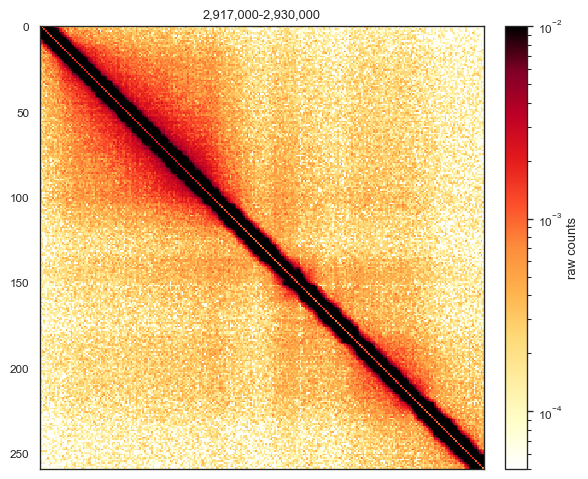

In [31]:
from matplotlib.colors import LogNorm

start = 2917_000
end = 2930_000
region = ('NC_000913.3', start, end)

norm_raw = LogNorm(vmin=5e-5, vmax=1e-2)

f, ax = plt.subplots(
    figsize=(7,6))

im = ax.matshow(
        clr.matrix(balance=True).fetch(region), 
    norm=norm_raw,  
    cmap='fall'
); 
plt.colorbar(im ,fraction=0.046, pad=0.04, label='raw counts')
ax.set_title(f'{start:,}-{end:,}')
ax.xaxis.set_visible(False)

# ax.set(#xticks=chromstarts, xticklabels=clr.chromnames,
#        xlabel='position, chrom#', ylabel='position, bin#')
ax.xaxis.set_label_position('top')

# Scaling

In [2]:
# %% create bins
resolution = 10
clr = cooler.Cooler('data/wt.combined.MG1655.mapq30.10.mcool::resolutions/' + str(resolution))
df_chromsizes = clr.chromsizes
bins = cooler.binnify(df_chromsizes, 25)
bins.chrom = bins.chrom.astype(str)
fasta_records = bf.load_fasta('data/genome.fasta')
view_df_chromsizes = clr.chromsizes.reset_index()
view_df_chromsizes.columns = ['chrom', 'end']
view_df_chromsizes['start'] = 0
view_df_chromsizes['name'] = 'NC_000913.3'
view_df_chromsizes = view_df_chromsizes[['chrom', 'start', 'end', 'name']]

In [3]:
cooler_dir='data/cool_reps/'
cooler_names = []
cooler_files = []
for fname in sorted(os.listdir(cooler_dir)):
    cooler_path = os.path.join(cooler_dir, fname)  # + '::/resolutions/2000'
    if os.path.isdir(cooler_path):
        # skip directories
        continue
    else:
        cooler_names.append(fname.split(".")[0])
cooler_names

['rif25_rep1',
 'rif25_rep2',
 'rif750_rep1',
 'rif750_rep2',
 'wt_44C_rep1',
 'wt_44C_rep2',
 'wt_rep1',
 'wt_rep2']

In [4]:
# cvd == contacts-vs-distance
num_reads = {}
cvds = {}
cvds_smoothed = {}
derivs_smoothed = {}
for name in cooler_names:
    if name in ['wt_44C_rep1', 'wt_44C_rep2', 'wt_rep1',  'wt_rep2']:
        clr = cooler.Cooler("data/cool_reps/%s.MG1655.merged.mapq_30.10.mcool::resolutions/%s" 
                        % (name, resolution))
    else:
        clr = cooler.Cooler("data/cool_reps/%s.MG1655.mapq_30.10.mcool::resolutions/%s" 
                        % (name, resolution))
    # cvds[name] = cooltools.expected_cis(
    #     clr=clr,
    #     view_df=view_df_chromsizes,
    #     smooth=False,
    #     aggregate_smoothed=False,
    #     nproc=32 #if you do not have multiple cores available, set to 1
    # )
    

    cvd_smooth_agg_downsampled = cooltools.expected_cis(
        clr=clr,
        view_df=view_df_chromsizes,
        smooth=True,
        aggregate_smoothed=True,
        nproc=32
    )
    cvd_smooth_agg_downsampled.loc[
        cvd_smooth_agg_downsampled['dist'] < 2, 'balanced.avg.smoothed'] = np.nan
    cvds_smoothed[name] = cvd_smooth_agg_downsampled

    cvd_merged = cvd_smooth_agg_downsampled.drop_duplicates(
        subset=['dist'])[['dist_bp', 'balanced.avg.smoothed.agg']]
    der = np.gradient(np.log(cvd_merged['balanced.avg.smoothed.agg']),
                    np.log(cvd_merged['dist_bp']))    
    derivs_smoothed[name] = der

INFO:root:creating a Pool of 32 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/scratch/ipykernel_2028167/1542618606.py:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = valu

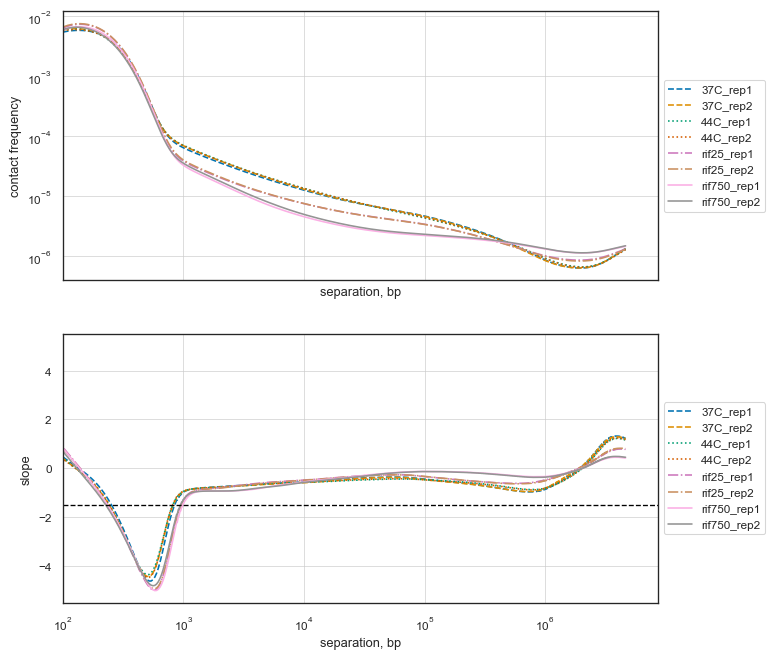

In [16]:
f, ax = plt.subplots(2,1, figsize=(8, 8), sharex=True)
# sns.color_palette("Paired")
sns.set_theme(context="paper", style='white', palette='colorblind', font="Arial")

cooler_names_di = {'rif25_rep1': 'rif25_rep1',
 'rif25_rep2': 'rif25_rep2',
 'rif750_rep1': 'rif750_rep1',
 'rif750_rep2': 'rif750_rep2',
 'wt_44C_rep1': '44C_rep1',
 'wt_44C_rep2': '44C_rep2',
 'wt_rep1': '37С_rep1',
 'wt_rep2': '37С_rep2'}

cooler_names_sorted = ['wt_rep1',
 'wt_rep2','wt_44C_rep1',
 'wt_44C_rep2', 'rif25_rep1',
 'rif25_rep2',
 'rif750_rep1',
 'rif750_rep2',
 
 ]
for name in cooler_names_sorted:
    if name in ['wt_rep1', 'wt_rep2']:
        style_line = 'dashed'
    elif name in ['wt_44C_rep1', 'wt_44C_rep2']:
        style_line=':'
    elif name in ['rif25_rep1', 'rif25_rep2']:
        style_line='-.'
    else:
        style_line='solid'
    cvd_downsampled = cvds_smoothed[name]
    cvd_downsampled.loc[cvd_downsampled['dist_bp'] < 100, 'balanced.avg.smoothed.agg'] = np.nan
    ax[0].loglog(
        cvd_downsampled['dist_bp'],
        cvd_downsampled['balanced.avg.smoothed.agg'],
        label=cooler_names_di[name], ls=style_line
    )
    der = derivs_smoothed[name]
    # der.loc[der['dist_bp'] < 100, 'balanced.avg.smoothed.agg'] = np.nan
    ax[1].semilogx(
        cvd_smooth_agg_downsampled['dist_bp'],
        der,
        label=cooler_names_di[name], ls=style_line
        )
for i in range(2):
    if i == 0:
        ylabel_name='contact frequency'
    else:
        ylabel_name='slope'
    ax[i].set(
        xlabel='separation, bp', 
        ylabel=ylabel_name)
    ax[i].grid(lw=0.5)
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].axhline(-1.5, 0, 1, color='black', linestyle='--', linewidth=1)
# ax[0].title.set_text(region)
ax[0].set_xlim(xmin=1e2)
# ax[1].set_ylim(xmin=1e2)
# plt.ylim(-2.25,.25)
f.savefig("results/scaling.smoothed.100bp.pdf", format="pdf", dpi=300, bbox_inches='tight')
f.show()
# f.clf()